In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Keras neural network model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras import optimizers, regularizers, initializers
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization

# Scikit-sklearn preprocessing modules
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Matplotlib and plotly modules
import matplotlib.pyplot as plt
from matplotlib import ticker
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [ ]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [ ]:
df_total = pd.read_csv("data/total_200.csv")

In [ ]:
df_total.columns

In [ ]:
# df_deviatoric = df_deviatoric.drop_duplicates()
# df_deviatoric_nsw = df_deviatoric_nsw.drop_duplicates()
df_total = df_total.drop_duplicates()
# df_total_nsw = df_total_nsw.drop_duplicates()

In [323]:
threshold = 0.15
# df_deviatoric['plastic strain'] = np.where(df_deviatoric['plastic strain'] > threshold, 1,0)
# df_deviatoric_nsw['plastic strain'] = np.where(df_deviatoric_nsw['plastic strain'] > threshold, 1,0)
df_total['plastic strain'] = np.where(df_total['plastic strain'] > threshold, 1,0)
# df_total_nsw['plastic strain'] = np.where(df_total_nsw['plastic strain'] > threshold, 1,0)

In [324]:
def drop_and_split_coloumns(df):
    
    dropped_cols = ['plastic strain', 'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
           'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
           'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
           'strain XX', 'strain ZZ', 'strain XZ', 'coordinate:0', 'coordinate:1', 'force:0', 'force:1', 
           'total displacement:0', 'total displacement:1', 'stress I', 'stress II', 'energy_volumetric', 
           'energy_deviatoric','energy_thermal', 'energy_elastic', 'thermal_stress',
           'energy_total_vol_dev', 'temp_power', 'temp_pressure', 'temp_density']

    Y = df['plastic strain']
    df = df.drop(dropped_cols, axis=1)
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    
    return X_train, X_test, y_train, y_test, df

In [325]:
X_train_dev, X_test_dev, Y_train_dev, Y_test_dev, df_deviatoric = drop_and_split_coloumns(df_deviatoric)
X_train_dev_nsw, X_test_dev_nsw, Y_train_dev_nsw, Y_test_dev_nsw, df_deviatoric_nsw = drop_and_split_coloumns(df_deviatoric_nsw)
X_train_tot, X_test_tot, Y_train_tot, Y_test_tot, df_total = drop_and_split_coloumns(df_total)
X_train_tot_nsw, X_test_tot_nsw, Y_train_tot_nsw, Y_test_tot_nsw, df_total_nsw = drop_and_split_coloumns(df_total_nsw)

In [326]:
xtrains = [X_train_dev, X_train_dev_nsw, X_train_tot, X_train_tot_nsw]
xtests = [X_test_dev, X_test_dev_nsw, X_test_tot, X_test_tot_nsw]
ytrains = [Y_train_dev, Y_train_dev_nsw, Y_train_tot, Y_train_tot_nsw]
ytests = [Y_test_dev, Y_test_dev_nsw, Y_test_tot, Y_test_tot_nsw]
models_name = ['Deviatoric', 'Deviatoric_nsw', 'Total', 'Total_nsw']

In [327]:
def scale_feature(features):    
    mms = StandardScaler()
    scaled_features = mms.fit_transform(features)
    return scaled_features, mms

In [328]:
mms = [None, None, None, None]
for i in range(len(models_name)):
    xtrains[i], mms[i] = scale_feature(xtrains[i])
    xtests[i], mms[i] = scale_feature(xtests[i])

## Neural network model

In [329]:
class build_neural_network:
    
    def __init__(self, model_name, xtrain, ytrain, xtest, ytest):
        self.model_name = model_name
        self.xtrain = xtrain
        self.ytrain = to_categorical(ytrain)
        self.xtest = xtest
        self.ytest = to_categorical(ytest)
        self.input_shape = np.shape(xtrain)[1]
        self.output_shape = np.shape(self.ytrain)[1]
        self.model = None
        self.ypred = None
        self.weight_path = "./weights/"
            
    def get_model_weights(self):
        return self.model.get_weights()

    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(self.input_shape, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 2018), 
                             activation = 'relu', name='layer_1',
                             input_shape = (self.input_shape,)))
        
        self.model.add(Dense(12, activation = 'relu', name='layer_2'))
            
        self.model.add(Dense(self.output_shape, activation="softmax", name='Output_layer'))
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
    
    def train_model(self, training_epochs):
        self.create_model()
        
        filepath = self.weight_path + str(self.model_name) + '.hdf5'
        
        if not os.path.exists(self.weight_path):
            os.makedirs(self.weight_path)
        
        checkpoint = ModelCheckpoint(filepath, verbose=0, period = training_epochs)
        self.model.fit(self.xtrain, self.ytrain, batch_size = 10, epochs = training_epochs, 
        callbacks = [checkpoint],
        validation_split = 0.3)
        
        self.save_model()
        
    def save_model(self):
        file_name = str(self.weight_path) + str(self.model_name)
        self.model.save(file_name)
    
    def predict(self):
        self.ypred = self.model.predict(self.xtest)
        
    def classification_report(self):
        self.predict()
        Y_test_class = np.argmax(self.ytest, axis = 1)
        Y_pred_class = np.argmax(self.ypred, axis = 1)
        print('Accuracy: {}'.format(accuracy_score(Y_test_class, Y_pred_class)))
        print('Classification report: \n {} \n'.format(classification_report(Y_test_class, Y_pred_class)))
        print('Confusion matrix: {}'.format(confusion_matrix(Y_test_class, Y_pred_class)))
    
    def set_color_bar(self, a, fig, cbar_min, cbar_max):
        fig.subplots_adjust(hspace=0.5)
        tick_v = np.linspace(cbar_min, cbar_max, 20, endpoint=True)
        fig.colorbar(a, orientation='vertical', ticks = tick_v)
    
    def plot_model_weights(self, figsize):    
        model_weights = []
        weights = self.get_model_weights()
        
        layer_1_weights = weights[0]
        layer_2_weights = weights[4]    
        
        cbar_max = np.amax([np.amax(layer_1_weights), np.amax(layer_2_weights)])
        cbar_min = np.amin([np.amin(layer_1_weights), np.amin(layer_2_weights)])
        
        # Layer-1
        fig = plt.figure(figsize= figsize)
        plt.subplot(1,2, 1)
        mesh_plot = plt.pcolormesh(np.transpose(weights[0]), clim=(cbar_min, cbar_max))
        labels = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
        plt.xticks([0.5+float(x) for x in range(0, len(labels))], labels, rotation='vertical')
        plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
        plt.ylabel('Hidden Units')
        
        # Output layer
        plt.subplot(1, 2, 2)
        bb = np.reshape(weights[1], (self.input_shape, 1))
        mesh_plot = plt.pcolormesh(bb, clim=(cbar_min, cbar_max))
        plt.xticks([0.5],['Output Unit'],rotation='vertical')
        plt.yticks([0.5+float(x) for x in range(0, len(labels))], list(range(1,13)))
        self.set_color_bar(mesh_plot, fig, cbar_min, cbar_max)

        plt.tight_layout()
        plt.show()


In [515]:
model_number = 2 # 0 = deviatoric, 1 = Dev_nsw, 2 = total, 3 = total_nsw
xtrain = xtrains[model_number]
ytrain = ytrains[model_number]
xtest = xtests[model_number]
ytest = ytests[model_number]

In [516]:
total = build_neural_network(models_name[model_number], xtrain, ytrain, xtest, ytest)

In [517]:
total.train_model(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                96        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
Train on 1216861 samples, validate on 521512 samples
Epoch 1/3
1216861/1216861 [==============================] - 519s - loss: 0.0603 - acc: 0.9793 - val_loss: 0.0551 - val_acc: 0.9812
Epoch 2/3
1216861/1216861 [==============================] - 510s - loss: 0.0544 - acc: 0.9811 - val_loss: 0.0542 - val_acc: 0.9810
Epoch 3/3
1216861/1216861 [==============================] - 502s - loss: 0.0529 - acc: 0.9

In [518]:
total.classification_report()

Accuracy: 0.9816071558002626
Classification report: 
              precision    recall  f1-score   support

          0       0.98      0.98      0.98    336591
          1       0.98      0.99      0.98    408427

avg / total       0.98      0.98      0.98    745018
 

Confusion matrix: [[328359   8232]
 [  5471 402956]]


## different model test

In [521]:
df_energy = pd.read_csv("data/test_energy_300.csv")

In [522]:
df_energy = df_energy.drop_duplicates()

In [523]:
threshold = 0.15
df_energy['plastic strain'] = np.where(df_energy['plastic strain'] > threshold, 1,0)

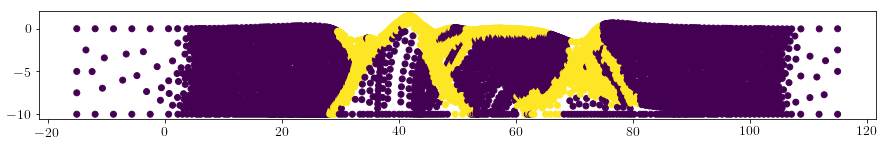

In [524]:
plt.figure(figsize=(15,2))
plt.scatter(df_energy['coordinate:0']/1e3, y= df_energy['coordinate:1']/1e3, c = df_energy['plastic strain'])
plt.show()

In [525]:
cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']
energy_x = df_energy[cols]

In [526]:
scale = mms[model_number]
test_features = scale.fit_transform(energy_x)

In [527]:
new_ypred = np.argmax(deviatoric.model.predict(test_features), axis = 1)

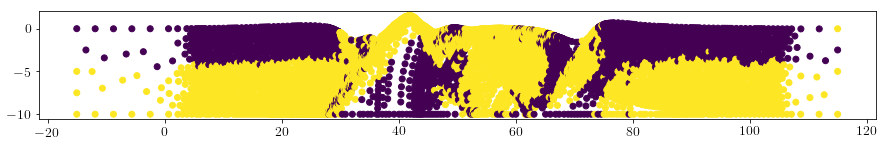

In [528]:
plt.figure(figsize=(15,2))
plt.scatter(df_energy['coordinate:0']/1e3, y= df_energy['coordinate:1']/1e3, c = new_ypred)
plt.show()

In [529]:
print('Accuracy: {}\n'.format(accuracy_score(df_energy['plastic strain'], new_ypred)))
print('Classification report: \n {}\n'.format(classification_report(df_energy['plastic strain'], new_ypred)))
print('Confusion matrix: \n{}'.format(confusion_matrix(df_energy['plastic strain'], new_ypred)))

Accuracy: 0.6548079941404207

Classification report: 
              precision    recall  f1-score   support

          0       0.73      0.34      0.46      4198
          1       0.64      0.90      0.75      5359

avg / total       0.68      0.65      0.62      9557


Confusion matrix: 
[[1423 2775]
 [ 524 4835]]
